# 2022 PICES Summer School: Glider project

Data source: https://gliders.ioos.us/map/#

Glider #: ce_383-20220720T1508, ce_320-20220720T1429

In [20]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d, interp1d
import cmocean
import gsw

from datetime import datetime, timedelta
import cartopy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

%matplotlib inline

# Read data

In [2]:
da_deep = xr.open_dataset('ce_383-20220720T1508_1775_5fb4_a04f.nc')
da_shallow = xr.open_dataset('ce_320-20220720T1429_ceb7_d730_d48a.nc')

## Glider vertical velocity

In [189]:
def moving_average(x, w):
    '''x: array,
    w: window size'''
    return np.convolve(x, np.ones(w), 'valid') / w

def vel(da):
    '''return glider velocity'''
    
    time = da.precise_time.values
    depth = da.depth.values
    vel = np.diff(depth) / (np.diff(time) / np.timedelta64(1, 's'))
    
    return vel

Text(-124.05, 200, 'Moving up')

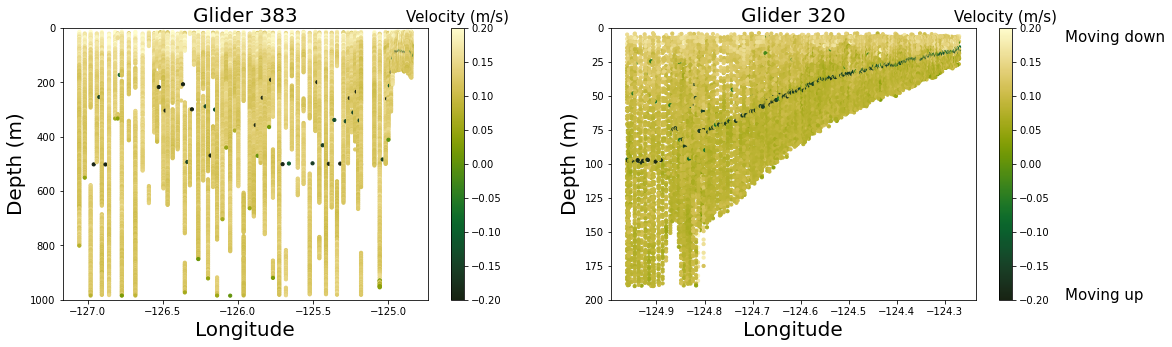

In [187]:
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

FONTSIZE = 20
sca = ax.scatter(moving_average(da_deep.longitude.values, 2), moving_average(da_deep.depth.values, 2), \
                 s=10, c=vel(da_deep),  cmap=cmocean.cm.speed_r, vmin=-0.2, vmax=0.2)
sca1 = ax1.scatter(moving_average(da_shallow.longitude.values, 2), moving_average(da_shallow.depth.values, 2), \
                   s=10, c=vel(da_shallow), cmap=cmocean.cm.speed_r, vmin=-0.2, vmax=0.2)

ax.set_ylim(1000,0)
ax1.set_ylim(200,0)

cb = fig.colorbar(sca, ax=ax, shrink=1)
cb1 = fig.colorbar(sca1, ax=ax1, shrink=1)
cb.ax.set_title('Velocity (m/s)', fontsize=FONTSIZE-5)
cb1.ax.set_title('Velocity (m/s)', fontsize=FONTSIZE-5)

ax.set_title('Glider 383', fontsize=FONTSIZE)
ax1.set_title('Glider 320', fontsize=FONTSIZE)

ax.set_xlabel('Longitude', fontsize=FONTSIZE)
ax1.set_xlabel('Longitude', fontsize=FONTSIZE)
ax.set_ylabel('Depth (m)', fontsize=FONTSIZE)
ax1.set_ylabel('Depth (m)', fontsize=FONTSIZE)

ax1.text(-124.05, 10, 'Moving down', fontsize=FONTSIZE-5)
ax1.text(-124.05, 200, 'Moving up', fontsize=FONTSIZE-5)

#plt.savefig('./figures/glider_speed.png', dpi=200, bbox_inches='tight')

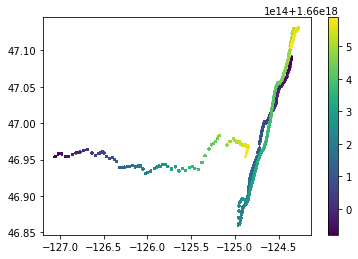

In [6]:
# glider scatter, time is time
plt.scatter(da_shallow.longitude, da_shallow.latitude, c=da_shallow.precise_time,s=2)
plt.colorbar()

plt.scatter(da_deep.longitude, da_deep.latitude, c=da_deep.precise_time,s=2)
#plt.scatter([lon_ref], [lat_ref], c='r')


## Pick a subset of the data

Text(0.5, 0, 'Time')

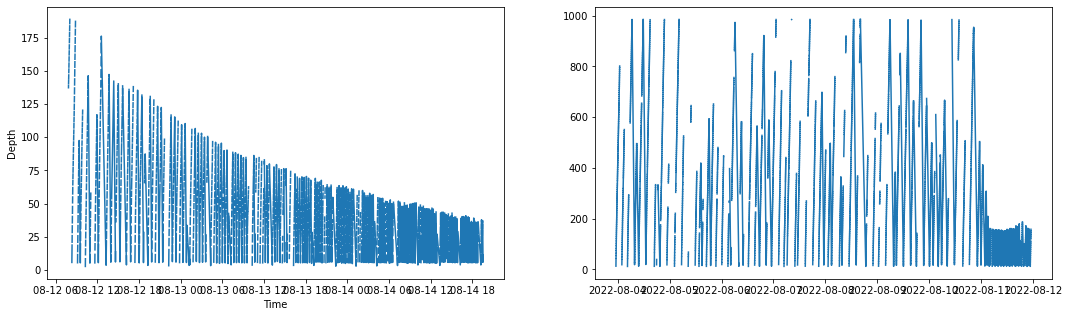

In [7]:
start = 14000
end = -2500

start_deep = 0
end_deep = -1

fig = plt.figure(figsize=(18,5))

ax = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

ax.plot(da_shallow.precise_time[start:end], da_shallow.depth[start:end])
ax1.plot(da_deep.precise_time[start_deep:end_deep], da_deep.depth[start_deep:end_deep])

ax.set_ylabel('Depth')
ax.set_xlabel('Time')

In [190]:
da = da_shallow.isel(row=slice(start, end))

# Map

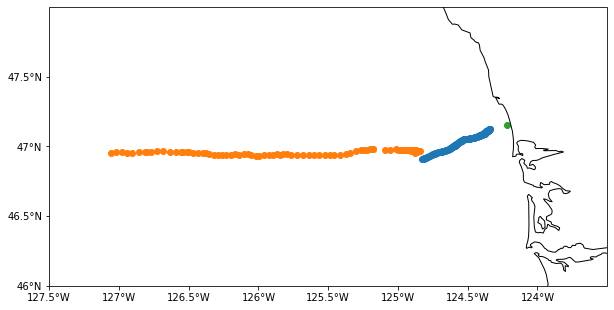

In [43]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
        
# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent([-127.5, -123.5, 46, 48], crs=ccrs.PlateCarree())
ax.coastlines()

sca = ax.scatter(section_sub.lon, section_sub.lat, transform=ccrs.PlateCarree())
ax.scatter(section_deep.lon, section_deep.lat, transform=ccrs.PlateCarree())

ax.scatter([-124.22],[47.15],  transform=ccrs.PlateCarree())

#ax.set_colorbar()
    
# mesh = ax.pcolormesh(data.xh, data.yh, data.isel(time=i*6).sst,
#                         vmin=vmin, vmax=vmax,
#                         cmap = cmocean.cm.balance,
#                         transform=ccrs.PlateCarree()
#                         )
    
# add terrain image
# stamen_terrain = cimgt.Stamen('terrain-background')
# ax.add_image(stamen_terrain, 8)

# t = traj.isel(obs=i)
# ax.scatter(t.lon, t.lat, color='k', s=0.2)


#cb = fig.colorbar(sca, shrink=0.3)
#cb.ax.set_title('deg C')
    
# # time in hours
# time = (field_par.time[i*6].values - field_par.time[0].values) / np.timedelta64(1, 'D')
    
# ax.set_title('SST', loc='left')
# ax.set_title('Day ' + str(round(time,1)), loc='right')

ax.set_xticks(np.arange(-127.5, -123.5, 0.5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(46, 48, 0.5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)  

# Interpolation

In [219]:
def uniq(da):
    '''Find unique longitudes, and treat them as stations. 
    Also return the depth range over which to interpolate.
    '''
    
    lon = np.unique(da.longitude.values)
    stn = np.array(range(lon.shape[0]))
    depth_int = np.array(range(0, int(np.max(da.depth).values+1), 3))
    
    return lon, stn, depth_int
    
def interp(da, station, lon, stn, depth_int):
    '''Given a dataset and station number, return interpolated variables.
    da: dataset
    station: a certain station
    lon, stn: uniques longitudes and station numbers
    depth_int: the depth range over which to interpolate
    '''
    
    # unique longitudes and stations
    lon, stn, depth_int = uniq(da)
    
    # pick a station
    s = da.where(da.longitude==lon[station], drop=True)
    lat = s.latitude.values[0] # corresponding latitude
    
    # original depth for this station 
    sd = s.depth.values 
    # variables to interpolate
    sn = np.vstack((s.density.values, s.salinity.values, s.temperature.values, \
                    s.chlorophyll.values, s.dissolved_oxygen.values, s.backscatter.values, \
                    #s.oxygen_saturation.values
                   ))

    f = interp1d(sd, sn, axis=1, fill_value='extrapolate') # fill those above the interpolation range
    da_int = f(depth_int) # interpolation
    da_int[da_int < 0] = np.nan # replace negative values with nan
    

    # make a dataset
    dataset = xr.Dataset(
         {
             'density': (('depth'), da_int[0,:]),
             'salinity': (('depth'), da_int[1,:]),
             'temperature': (('depth'), da_int[2,:]),
             'chlorophyll': (('depth'), da_int[3,:]),
             'oxygen': (('depth'), da_int[4,:]),
             'backscatter': (('depth'), da_int[5,:]),
             #'oxygen_saturation': (('depth'), da_int[6,:]),
             
         },
         coords = {
             'lon': lon[station],
             'lat':  lat,
             'depth': depth_int,
         })
    dataset = dataset.expand_dims({'station':[station]}) # add a new dimension as the station number
    
    return dataset

def getsection(da):
    '''Get section in an xarray dataset'''
    lon, stn, depth_int = uniq(da)
    
    # put all stations together
    for station in stn:   
        try:
            section = xr.concat([section, interp(da, station, lon, stn, depth_int)], 'station')    
        except:
            section = interp(da, station, lon, stn, depth_int)

    section.density.attrs['units'] = 'µmol/L'
    section.salinity.attrs['units'] = 'psu'
    section.temperature.attrs['units'] = 'deg C'
    section.chlorophyll.attrs['units'] = 'µg/L'
    section.oxygen.attrs['units'] = 'µmol/kg'
    section.depth.attrs['units'] = 'm'
    section.backscatter.attrs['units'] = '/m'
    #section.oxygen_saturation.attrs['units'] = '%'
    
    # add distance
    d = gsw.distance(section.lon.values, section.lat.values)/1e3  # distance between each station, km
    dist = np.cumsum(np.hstack((0,d))) #cumulative sum of dist

    section = section.assign_coords({'distance': xr.DataArray(np.flip(dist), coords = [section.station], dims = 'station')})
    section.distance.attrs['units'] = 'km'
    
    return section

In [220]:
section = getsection(da)

In [221]:
section_deep = getsection(da_deep)

In [154]:
def hori_res(section):
    return np.min(np.diff(section.distance.values)), np.max(np.diff(section.distance.values))

In [156]:
hori_res(section), hori_res(section_deep)

((-0.7753973135655574, -0.08460922824861683),
 (-6.88510223779673, -0.0006925709970744265))

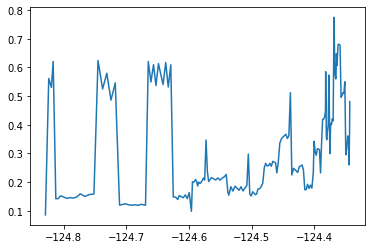

In [159]:
plt.plot(section.lon.values[:-1], -np.diff(section.distance.values))

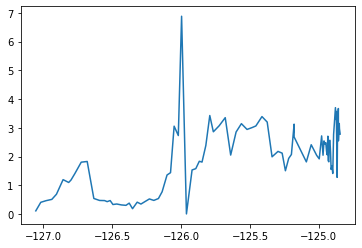

In [160]:
plt.plot(section_deep.lon.values[:-1], -np.diff(section_deep.distance.values))

## Notice there are "outliers" after interpolation

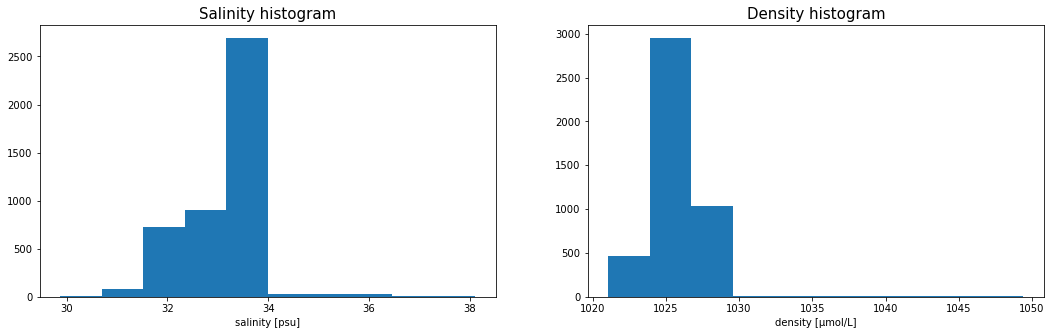

In [14]:
fig = plt.figure(figsize=(18,5))
FONTSIZE = 15
ax = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

section.salinity.plot.hist(ax=ax)
section.density.plot.hist(ax=ax1);

ax.set_title('Salinity histogram', fontsize=FONTSIZE)
ax1.set_title('Density histogram', fontsize=FONTSIZE);

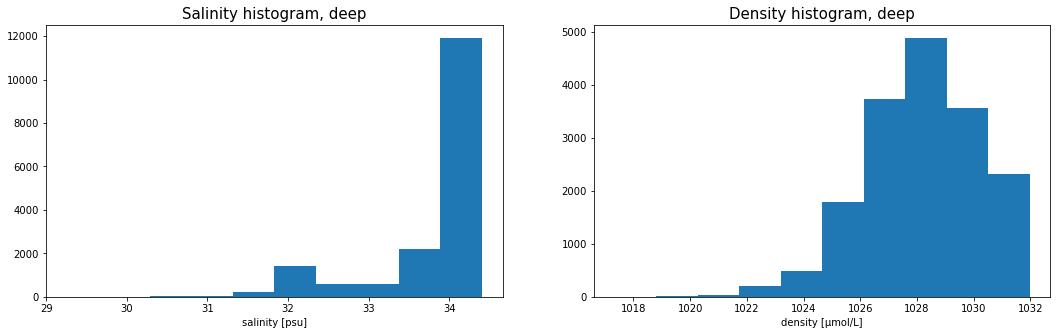

In [15]:
fig = plt.figure(figsize=(18,5))
FONTSIZE = 15
ax = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

section_deep.salinity.plot.hist(ax=ax)
section_deep.density.plot.hist(ax=ax1);

ax.set_title('Salinity histogram, deep', fontsize=FONTSIZE)
ax1.set_title('Density histogram, deep', fontsize=FONTSIZE);

### Remove outliers

In [198]:
section_sub = section.where( (section.salinity<35) & (section.density<1030), drop=True)

# Section plots

(array([3.648e+03, 2.740e+02, 1.230e+02, 4.500e+01, 1.000e+01, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([2.06774708e-03, 2.26924394e+00, 4.53642013e+00, 6.80359632e+00,
        9.07077252e+00, 1.13379487e+01, 1.36051249e+01, 1.58723011e+01,
        1.81394773e+01, 2.04066535e+01, 2.26738297e+01]),
 <BarContainer object of 10 artists>)

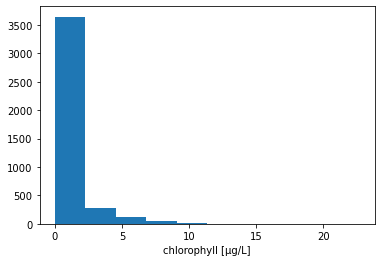

In [175]:
section_sub.chlorophyll.plot.hist()

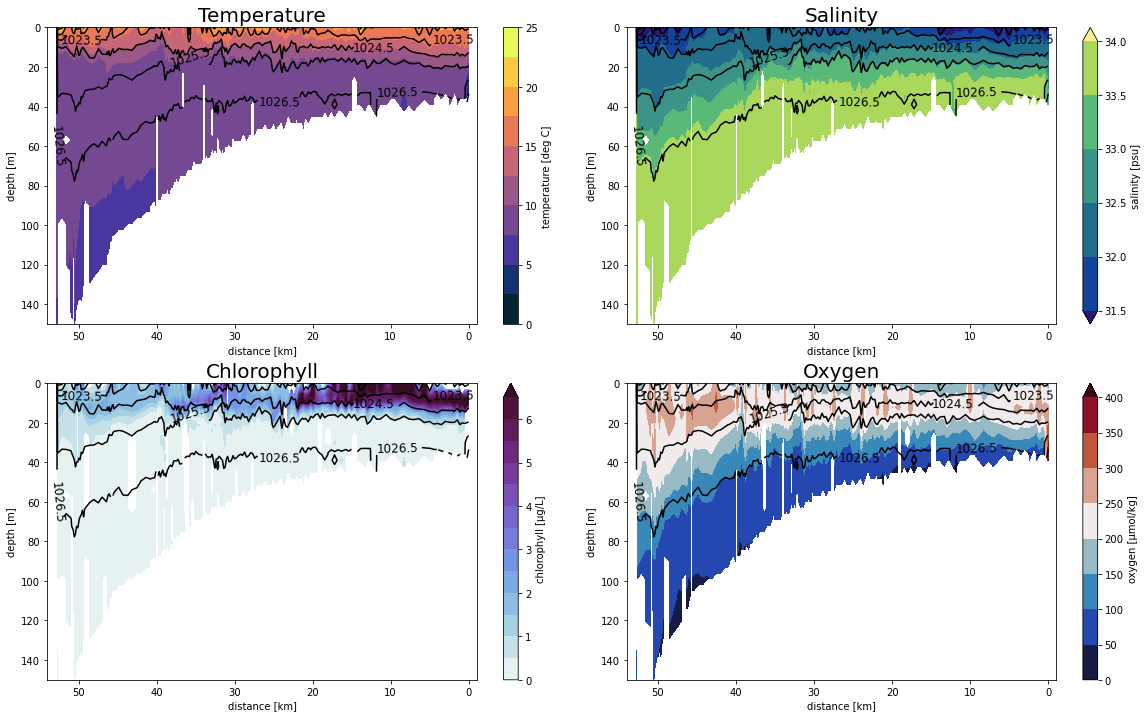

In [226]:
def add_density(ax):
    contours = section_sub.density.plot.contour('distance','depth', ax=ax, colors='k', levels=np.arange(1020.5, 1029.5, 1))
    plt.clabel(contours, inline=True, fmt='%1.1f', fontsize=12) # label densities

fig = plt.figure(figsize=(20,12))
FONTSIZE = 20
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2, sharex = ax1, sharey=ax1)
ax3 = fig.add_subplot(2, 2, 3, sharex = ax1, sharey=ax1)
ax4 = fig.add_subplot(2, 2, 4, sharex = ax1, sharey=ax1)

section_sub.temperature.plot.contourf('distance','depth', ax=ax1, cmap=cmocean.cm.thermal, levels=10) 
section_sub.salinity.plot.contourf('distance','depth', ax=ax2, cmap=cmocean.cm.haline, levels=np.arange(31.5, 34.5, 0.5)) 
section_sub.chlorophyll.plot.contourf('distance','depth', ax=ax3, cmap=cmocean.cm.dense, levels=np.arange(0, 7, 0.5)) 
section_sub.oxygen.plot.contourf('distance','depth', ax=ax4, cmap=cmocean.cm.balance, levels=np.arange(0, 420, 50)) 

add_density(ax1)
add_density(ax2)
add_density(ax3)
add_density(ax4)

ax1.set_ylim(150,0)
ax1.set_xlim(54,-1)

ax1.set_title('Temperature', fontsize=FONTSIZE)
ax2.set_title('Salinity', fontsize=FONTSIZE)
ax3.set_title('Chlorophyll', fontsize=FONTSIZE)
ax4.set_title('Oxygen', fontsize=FONTSIZE)

plt.subplots_adjust(wspace=0.08, hspace=0.2)

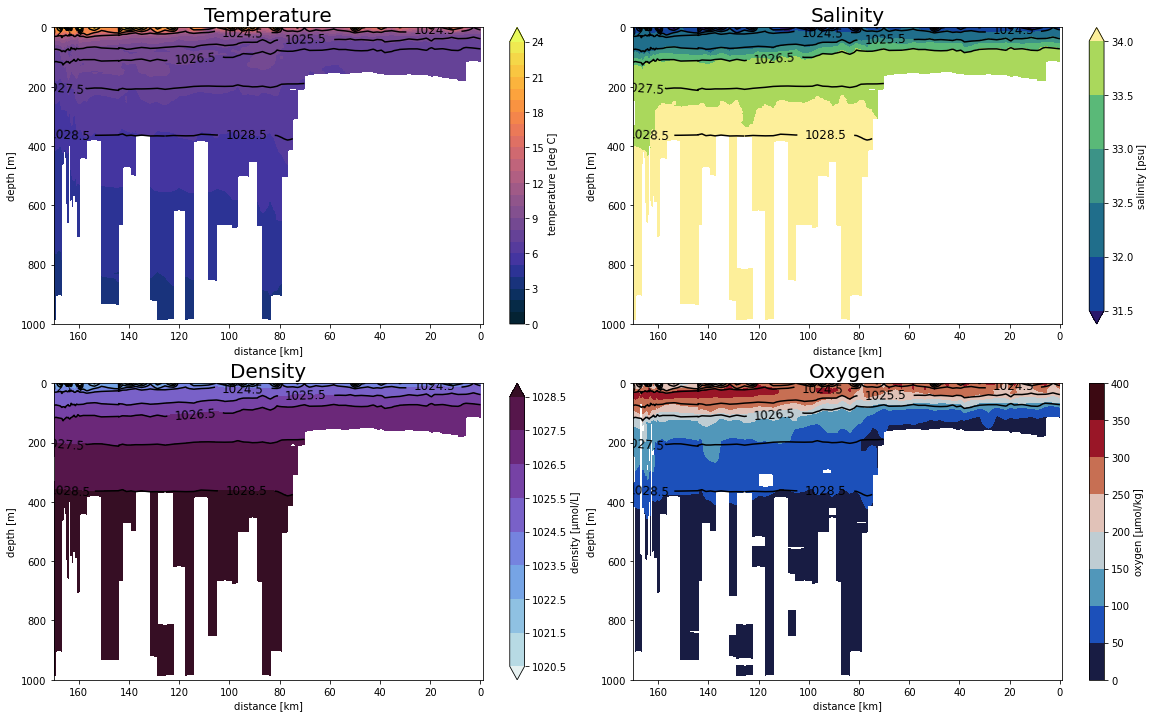

In [18]:
def add_density(ax):
    contours = section_deep.density.plot.contour('distance','depth', ax=ax, colors='k', levels=np.arange(1020.5, 1029.5, 1))
    plt.clabel(contours, inline=True, fmt='%1.1f', fontsize=12) # label densities

fig = plt.figure(figsize=(20,12))
FONTSIZE = 20
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2, sharex = ax1, sharey=ax1)
ax3 = fig.add_subplot(2, 2, 3, sharex = ax1, sharey=ax1)
ax4 = fig.add_subplot(2, 2, 4, sharex = ax1, sharey=ax1)

section_deep.temperature.plot.contourf('distance','depth', ax=ax1, cmap=cmocean.cm.thermal, levels=np.arange(0, 25, 1)) 
section_deep.salinity.plot.contourf('distance','depth', ax=ax2, cmap=cmocean.cm.haline, levels=np.arange(31.5, 34.5, 0.5)) 
section_deep.density.plot.contourf('distance','depth', ax=ax3, cmap=cmocean.cm.dense, levels=np.arange(1020.5, 1029.5, 1)) 
section_deep.oxygen.plot.contourf('distance','depth', ax=ax4, cmap=cmocean.cm.balance, levels=np.arange(0, 420, 50)) 

add_density(ax1)
add_density(ax2)
add_density(ax3)
add_density(ax4)

ax1.set_ylim(1000,0)
ax1.set_xlim(170,-1)

ax1.set_title('Temperature', fontsize=FONTSIZE)
ax2.set_title('Salinity', fontsize=FONTSIZE)
ax3.set_title('Density', fontsize=FONTSIZE)
ax4.set_title('Oxygen', fontsize=FONTSIZE)

plt.subplots_adjust(wspace=0.08, hspace=0.2)

# Stitch two datasets

In [222]:
def change_dist(section_deep_sub):
    '''change the distance, relative to the a coast point'''
    
    # change the distance, relative to the 1st point of 320 glider section
    lon_ref = -124.22
    lat_ref = 47.15

    lon_deep = section_deep_sub.lon.values
    lat_deep = section_deep_sub.lat.values
    lon_deep = np.flip(np.insert(lon_deep, lon_deep.size, lon_ref, axis=0)) # insert at the end
    lat_deep = np.flip(np.insert(lat_deep, lat_deep.size, lat_ref, axis=0))

    d = gsw.distance(lon_deep, lat_deep)/1e3  # distance between each station, km
    dist = np.cumsum(np.hstack((0,d))) #cumulative sum of dist

    section_deep_sub = section_deep_sub.drop({'distance'})
    section_deep_sub = section_deep_sub.assign_coords({'distance': xr.DataArray(np.flip(dist[1:]), coords = [section_deep_sub.station], dims = 'station')})

    section_deep_sub.distance.attrs['units'] = 'km'
    
    return section_deep_sub

def stitch(section_deep_sub, section_sub):
    '''stitch two datasets'''
    
    # subset the depth to match section_sub
    #s = section_deep_sub.isel(depth=slice(0,63))
    s = section_deep_sub # you don't need this actually, it will intepolate on its own
    
    # change station number
    with xr.set_options(keep_attrs=True):
        s = s.assign({'station': s.station+100})

    return xr.concat([s, section_sub], 'station')

In [223]:
# change distance
section_deep_dist = change_dist(section_deep)
section_dist = change_dist(section_sub)

# subset the deep glider, stations that are farther than glider 320
total_km = 50 # this many km in the deep glider
section_deep_dist_sub = section_deep_dist.where( (section_deep_dist.distance > section_dist.distance.values[0]) & \
                                                (section_deep_dist.distance < section_dist.distance.values[0] + total_km), drop=True)

# stitch data
two = stitch(section_deep_dist_sub, section_dist)

In [224]:
# rolling mean horizontally
two = two.rolling(station=3).mean()

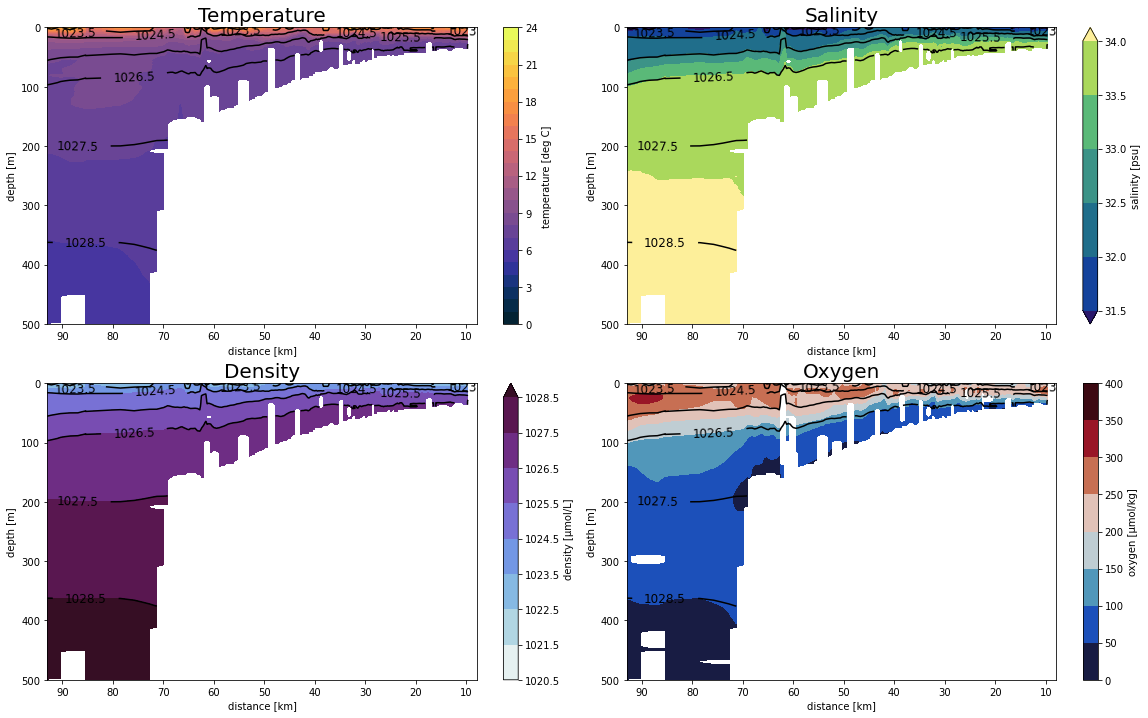

In [205]:
def add_density(ax):
    contours = two.density.plot.contour('distance','depth', ax=ax, colors='k', levels=np.arange(1020.5, 1029.5, 1))
    plt.clabel(contours, inline=True, fmt='%1.1f', fontsize=12) # label densities

fig = plt.figure(figsize=(20,12))
FONTSIZE = 20
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2, sharex = ax1, sharey=ax1)
ax3 = fig.add_subplot(2, 2, 3, sharex = ax1, sharey=ax1)
ax4 = fig.add_subplot(2, 2, 4, sharex = ax1, sharey=ax1)

two.temperature.plot.contourf('distance','depth', ax=ax1, cmap=cmocean.cm.thermal, levels=np.arange(0, 25, 1)) 
two.salinity.plot.contourf('distance','depth', ax=ax2, cmap=cmocean.cm.haline, levels=np.arange(31.5, 34.5, 0.5)) 
two.density.plot.contourf('distance','depth', ax=ax3, cmap=cmocean.cm.dense, levels=np.arange(1020.5, 1029.5, 1)) 
two.oxygen.plot.contourf('distance','depth', ax=ax4, cmap=cmocean.cm.balance, levels=np.arange(0, 420, 50)) 

add_density(ax1)
add_density(ax2)
add_density(ax3)
add_density(ax4)

ax1.set_ylim(500,0)
ax1.set_xlim(93,8)

ax1.set_title('Temperature', fontsize=FONTSIZE)
ax2.set_title('Salinity', fontsize=FONTSIZE)
ax3.set_title('Density', fontsize=FONTSIZE)
ax4.set_title('Oxygen', fontsize=FONTSIZE)

plt.subplots_adjust(wspace=0.08, hspace=0.2)

# Along isopycnals

In [206]:
# pick an isopycnal
iso = 1026.5
section_iso = two.where( np.round(two.density, 1) == iso, drop=True)
#section_iso_deep = section_deep.where( np.round(section_deep.density, 1) == iso, drop=True)

# mean
section_iso_mean = section_iso.mean(dim={'depth'}).rolling(station=10).mean()
#section_iso_mean_deep = section_iso_deep.mean(dim={'depth'}).rolling(station=10).mean()

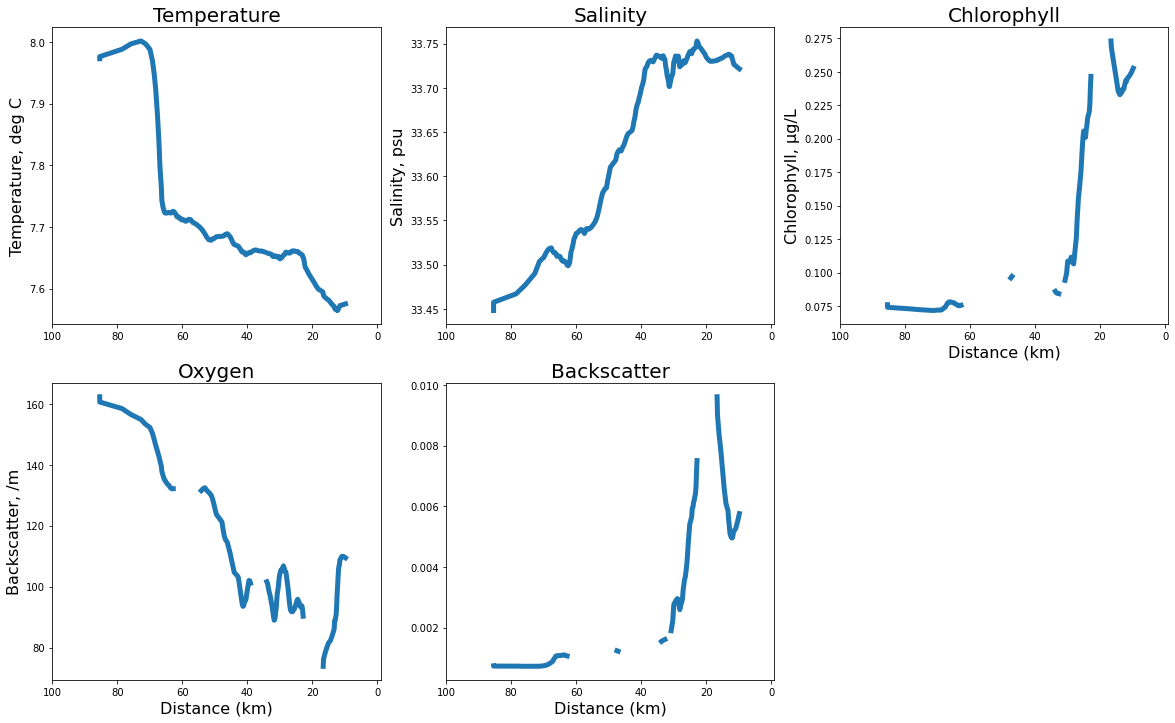

In [210]:
fig = plt.figure(figsize=(20,12))
FONTSIZE = 20
ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2, sharex = ax1)
ax3 = fig.add_subplot(2, 3, 3, sharex = ax1)
ax4 = fig.add_subplot(2, 3, 4, sharex = ax1)
ax5 = fig.add_subplot(2, 3, 5, sharex = ax1)

ax1.plot(section_iso_mean.distance, section_iso_mean.temperature, linewidth=5)
ax2.plot(section_iso_mean.distance, section_iso_mean.salinity, linewidth=5)
ax3.plot(section_iso_mean.distance, section_iso_mean.chlorophyll, linewidth=5)
ax4.plot(section_iso_mean.distance, section_iso_mean.oxygen, linewidth=5)
ax5.plot(section_iso_mean.distance, section_iso_mean.backscatter, linewidth=5)

ax1.set_xlim(100,-1)

ax1.set_title('Temperature', fontsize=FONTSIZE)
ax2.set_title('Salinity', fontsize=FONTSIZE)
ax3.set_title('Chlorophyll', fontsize=FONTSIZE)
ax4.set_title('Oxygen', fontsize=FONTSIZE)
ax5.set_title('Backscatter', fontsize=FONTSIZE)

# ax1.set_xlabel('Distance (km)')
# ax2.set_xlabel('Distance (km)')
ax3.set_xlabel('Distance (km)', fontsize=FONTSIZE-4)
ax4.set_xlabel('Distance (km)', fontsize=FONTSIZE-4)
ax5.set_xlabel('Distance (km)', fontsize=FONTSIZE-4)

ax1.set_ylabel('Temperature, deg C',fontsize=FONTSIZE-4)
ax2.set_ylabel('Salinity, psu',fontsize=FONTSIZE-4)
ax3.set_ylabel('Chlorophyll, µg/L',fontsize=FONTSIZE-4)
ax4.set_ylabel('Oxygen, µmol/kg', fontsize=FONTSIZE-4);
ax4.set_ylabel('Backscatter, /m', fontsize=FONTSIZE-4);

plt.savefig('./figures/isopycnal.png', dpi=200, bbox_inches='tight')

# T-S
Loop all the salinity temp, to have a matrix of density, and then plot a contour.

Spicyness: warm and salter, more spicy; otherwise more minty.

In [89]:
sal_cal = np.arange(25, 35, 0.1)
temp_cal = np.arange(3, 19, 0.1)
density_cal = np.zeros((temp_cal.shape[0], sal_cal.shape[0]))
spiciness_cal = np.zeros((temp_cal.shape[0], sal_cal.shape[0]))

for i in range(temp_cal.shape[0]):
    for j in range(sal_cal.shape[0]):
        density_cal[i,j] = xr.apply_ufunc(gsw.density.sigma0, sal_cal[j], temp_cal[i],
                    output_dtypes=[da.salinity.dtype])  # absolute density
        spiciness_cal[i,j] = xr.apply_ufunc(gsw.spiciness0, sal_cal[j], temp_cal[i],
                    output_dtypes=[da.salinity.dtype])  # absolute density

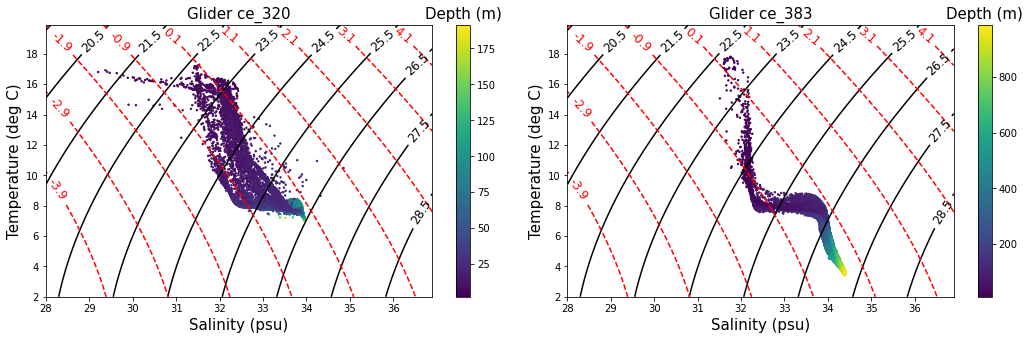

In [150]:
fig = plt.figure(figsize=(18,5))
FONTSIZE = 15
ax = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

sca = ax.scatter(da.salinity,  da.temperature,c=da.depth, s=2)
sca1 = ax1.scatter(da_deep.salinity,  da_deep.temperature,c=da_deep.depth, s=2)

# density contours
contours = ax.contour(sal_cal, temp_cal, density_cal, levels=np.arange(18.5, 29.5, 1), colors='k')
contours1 = ax1.contour(sal_cal, temp_cal, density_cal, levels=np.arange(18.5, 29.5, 1), colors='k')
plt.clabel(contours, inline=True, fmt='%1.1f', fontsize=12) # label densities
plt.clabel(contours1, inline=True, fmt='%1.1f', fontsize=12) # label densities

# spiciness contours
contours2 = ax.contour(sal_cal, temp_cal, spiciness_cal, levels=np.arange(-4.9, 4.8, 1), colors='r', linestyles = 'dashed')
contours3 = ax1.contour(sal_cal, temp_cal, spiciness_cal, levels=np.arange(-4.9, 4.8, 1), colors='r', linestyles = 'dashed')
plt.clabel(contours2, inline=True, fmt='%1.1f', fontsize=12) 
plt.clabel(contours3, inline=True, fmt='%1.1f', fontsize=12) 

ax.set_xlabel('Salinity (psu)', fontsize=FONTSIZE)
ax.set_ylabel('Temperature (deg C)', fontsize=FONTSIZE)
ax1.set_xlabel('Salinity (psu)', fontsize=FONTSIZE)
ax1.set_ylabel('Temperature (deg C)', fontsize=FONTSIZE)

cb = fig.colorbar(sca, ax=ax, shrink=1)
cb1 = fig.colorbar(sca1, ax=ax1, shrink=1)
cb.ax.set_title('Depth (m)', fontsize=FONTSIZE)
cb1.ax.set_title('Depth (m)', fontsize=FONTSIZE)

ax.set_title('Glider ce_320', fontsize=FONTSIZE)
ax1.set_title('Glider ce_383', fontsize=FONTSIZE)

plt.subplots_adjust( 
                    wspace=0.08, 
                    )
#plt.subplot_tool()